# Linear Regression & XGBoost

In [1]:
from src import data
from src import mlp

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In this notebook, we implement as a baseline various wave height prediction methods that leverage our data. We will begin with simple linear regression, examining different hyperparameters and regularization methods, then move into other prediction methods such as XGBoost.

### Collecting Data

In [2]:
# Buouy data paths for wave related measurements
DATA_PATH_2022 = 'data/targetstation46240/46240h2022.txt'
DATA_PATH_2021 = 'data/targetstation46240/46240h2021.txt'
DATA_PATH_2020 = 'data/targetstation46240/46240h2020.txt'
DATA_PATH_2019 = 'data/targetstation46240/46240h2019.txt'
DATA_PATH_2018 = 'data/targetstation46240/46240h2018.txt'
DATA_PATH_2017 = 'data/targetstation46240/46240h2017.txt'
DATA_PATH_2016 = 'data/targetstation46240/46240h2016.txt'
DATA_PATH_2015 = 'data/targetstation46240/46240h2015.txt'
DATA_PATH_2014 = 'data/targetstation46240/46240h2014.txt'
DATA_PATH_2013 = 'data/targetstation46240/46240h2013.txt'
DATA_PATH_2012 = 'data/targetstation46240/46240h2012.txt'
DATA_PATH_2011 = 'data/targetstation46240/46240h2011.txt'
DATA_PATH_2010 = 'data/targetstation46240/46240h2010.txt'
DATA_PATH_2009 = 'data/targetstation46240/46240h2009.txt'

We first consolidate all of our datapaths into one list to read them all into a large pandas dataframe for later examination. Our `station46240specs` represent the measurements that buoy 46240 off of Cabrillo Point in Monterey Bay, CA, are equipped to read.

In [41]:
file_paths = [DATA_PATH_2009,DATA_PATH_2010, DATA_PATH_2011, DATA_PATH_2012, DATA_PATH_2013, 
              DATA_PATH_2014, DATA_PATH_2015, DATA_PATH_2016, DATA_PATH_2017, DATA_PATH_2018, 
              DATA_PATH_2019, DATA_PATH_2020, DATA_PATH_2021, DATA_PATH_2022]

station46240specs = ['WVHT', 'DPD', 'APD', 'MWD']

# Re-reading and combining data from all files with outliers replaced by NaN
all_wave_data_46240 = pd.concat([data.process_file_to_hourly_last(file) for file in file_paths])

all_wave_data_46240.drop(columns=['WDIR', 'WSPD', 'GST', 'PRES', 'DEWP', 'VIS', 'TIDE', 'ATMP'], inplace=True)

all_wave_data_46240.shape

(116706, 9)

Our data is formatted below. As we can see, we processed it to contain data measured hourly starting in 2009 going all the way to the end of 2022. 

In [42]:
all_wave_data_46240[all_wave_data_46240.isnull().any(axis=1)]

,Year,Month,Day,Hour,WVHT,DPD,APD,MWD,WTMP
datetime,,,,,,,,,
2009-04-06 23:00:00,2009,4,6,23,0.96,15.38,11.37,7.0,NaN
2009-04-07 00:00:00,2009,4,7,0,0.83,11.76,10.87,354.0,NaN
2009-04-08 01:00:00,2009,4,8,1,0.87,12.50,10.72,352.0,NaN
2009-04-08 02:00:00,2009,4,8,2,0.88,11.76,10.62,347.0,NaN
2009-04-08 03:00:00,2009,4,8,3,0.75,11.76,10.31,349.0,NaN
...,...,...,...,...,...,...,...,...,...
2022-08-31 08:00:00,2022,8,31,8,0.20,NaN,5.65,NaN,15.7
2022-08-31 09:00:00,2022,8,31,9,0.21,NaN,5.84,NaN,15.6
2022-08-31 10:00:00,2022,8,31,10,0.23,NaN,5.85,NaN,15.6


The buoy unfortunately experiences gaps in its recording of some datapoints (which are represented as `NaN`) so we will drop those, leaving us with 116,387 datapoints, each with 5 features: wave height, dominiant wave period (DPD), average wave period (APD), direction of dominant wave period (MWD), and sea surface temperature (WTMP).

In [45]:
# drop rows that contain NaN values
all_wave_data_46240.dropna(inplace=True)
print(all_wave_data_46240.shape)
all_wave_data_46240.head()

(116387, 8)


,Year,Month,Day,Hour,WVHT,DPD,APD,MWD
datetime,,,,,,,,
2009-01-01 00:00:00,2009,1,1,0,1.12,11.76,7.91,352.0
2009-01-01 01:00:00,2009,1,1,1,1.02,10.53,6.31,346.0
2009-01-01 02:00:00,2009,1,1,2,1.07,11.11,5.61,352.0
2009-01-01 03:00:00,2009,1,1,3,1.14,11.76,5.42,352.0
2009-01-01 04:00:00,2009,1,1,4,1.00,13.33,5.65,359.0


In [53]:
from src.data import process_file_to_hourly_last

WIND_DATA_2022 = './data/windstation46092/46092h2022.txt'
WIND_DATA_2021 = './data/windstation46092/46092h2021.txt'
WIND_DATA_2020 = './data/windstation46092/46092h2020.txt'
WIND_DATA_2019 = './data/windstation46092/46092h2019.txt'
WIND_DATA_2018 = './data/windstation46092/46092h2018.txt'
WIND_DATA_2017 = './data/windstation46092/46092h2017.txt'
WIND_DATA_2016 = './data/windstation46092/46092h2016.txt'
WIND_DATA_2015 = './data/windstation46092/46092h2015.txt'
WIND_DATA_2014 = './data/windstation46092/46092h2014.txt'
WIND_DATA_2013 = './data/windstation46092/46092h2013.txt'
WIND_DATA_2012 = './data/windstation46092/46092h2012.txt'
WIND_DATA_2011 = './data/windstation46092/46092h2011.txt'
WIND_DATA_2010 = './data/windstation46092/46092h2010.txt'
WIND_DATA_2009 = './data/windstation46092/46092h2009.txt'

file_paths_46092 = [WIND_DATA_2009, WIND_DATA_2010, WIND_DATA_2011, WIND_DATA_2012, WIND_DATA_2013, 
                    WIND_DATA_2014, WIND_DATA_2015, WIND_DATA_2016, WIND_DATA_2017, WIND_DATA_2018,
                    WIND_DATA_2019, WIND_DATA_2020, WIND_DATA_2021, WIND_DATA_2022]

all_data_46092 = pd.concat([process_file_to_hourly_last(file) for file in file_paths_46092])
# Anomaly: 2009 contains Dec 31 2008
first_row_index = all_data_46092.index[0]  # Get the index of the first row
all_data_46092 = all_data_46092.drop(first_row_index)  # Drop the first row

all_data_46092

,Year,Month,Day,Hour,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
datetime,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00,2009,1,1,0,290.0,9.3,NaN,NaN,NaN,NaN,NaN,1020.5,8.7,12.0,NaN,NaN,NaN
2009-01-01 01:00:00,2009,1,1,1,290.0,10.3,NaN,NaN,NaN,NaN,NaN,1020.3,8.9,11.9,NaN,NaN,NaN
2009-01-01 02:00:00,2009,1,1,2,280.0,9.3,NaN,NaN,NaN,NaN,NaN,1020.4,9.1,11.9,NaN,NaN,NaN
2009-01-01 03:00:00,2009,1,1,3,300.0,7.7,NaN,NaN,NaN,NaN,NaN,1020.9,9.7,11.9,NaN,NaN,NaN
2009-01-01 04:00:00,2009,1,1,4,330.0,6.2,NaN,NaN,NaN,NaN,NaN,1020.6,9.1,11.9,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,2022,12,31,19,160.0,12.9,NaN,NaN,NaN,NaN,NaN,1006.7,13.6,13.2,NaN,NaN,NaN
2022-12-31 20:00:00,2022,12,31,20,150.0,13.4,NaN,NaN,NaN,NaN,NaN,1004.4,13.8,13.2,NaN,NaN,NaN
2022-12-31 21:00:00,2022,12,31,21,150.0,13.9,NaN,NaN,NaN,NaN,NaN,1002.8,13.8,13.2,NaN,NaN,NaN


In [66]:
# Merge the two DataFrames on the 'datetime' column
merged_df = all_wave_data_46240.merge(all_data_46092, on='datetime', how='inner')

final_df = merged_df.reset_index()
# Selecting and renaming columns
final_df = final_df[['datetime', 'WVHT_x', 'DPD_x', 'APD_x', 'MWD_x', 'WDIR', 'WSPD', 'PRES', 'ATMP', 'WTMP']].copy()
final_df.columns = ['datetime', 'WVHT', 'DPD', 'APD', 'MWD', 'WDIR', 'WSPD', 'PRES', 'ATMP', 'WTMP']
final_df.set_index('datetime', inplace=True)

# Calculate the mean for each column
column_means = final_df.mean()

# Fill NaNs with the mean of their respective column
final_df.fillna(column_means, inplace=True)

# Check if there are any NaNs left
# print(final_df.isna().any())

final_df

,WVHT,DPD,APD,MWD,WDIR,WSPD,PRES,ATMP,WTMP
datetime,,,,,,,,,
2009-01-01 00:00:00,1.12,11.76,7.91,352.0,290.0,9.3,1020.5,8.7,12.0
2009-01-01 01:00:00,1.02,10.53,6.31,346.0,290.0,10.3,1020.3,8.9,11.9
2009-01-01 02:00:00,1.07,11.11,5.61,352.0,280.0,9.3,1020.4,9.1,11.9
2009-01-01 03:00:00,1.14,11.76,5.42,352.0,300.0,7.7,1020.9,9.7,11.9
2009-01-01 04:00:00,1.00,13.33,5.65,359.0,330.0,6.2,1020.6,9.1,11.9
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,1.19,10.53,9.75,341.0,160.0,12.9,1006.7,13.6,13.2
2022-12-31 20:00:00,1.37,11.11,10.35,345.0,150.0,13.4,1004.4,13.8,13.2
2022-12-31 21:00:00,1.21,11.76,9.90,348.0,150.0,13.9,1002.8,13.8,13.2


### Splitting the Data

We now split the data into a training set, a validation set, and a testing set. Our training set will contain hourly data from 2009 to 2018, our validation set will hold 2019 and 2020, and our testing set will contain 2021 and 2022. 

In [69]:
train_df = final_df[final_df.index.year <= 2018]
val_df = final_df[(final_df.index.year == 2019) | (final_df.index.year == 2020)]

# WE WILL NOT TOUCH THIS UNTIL THE FINAL MODEL
test_df = final_df[(final_df.index.year == 2021) | (final_df.index.year == 2022)]

Due to some measurements not being sequential, we use `check_for_missing_rows` to further format our data to be sequential, hourly data. As we can see, there are 614 missing indices in our training, 49 in our validation, and 16 in our test, so we will remove them.

In [70]:
missing_indices_train = data.check_for_missing_rows(train_df)
len(missing_indices_train)

2858

In [71]:
missing_indices_val = data.check_for_missing_rows(val_df)
len(missing_indices_val)

489

In [72]:
missing_indices_test = data.check_for_missing_rows(test_df)
len(missing_indices_test)

164

### Training a Basic Linear Regressor

We will now use our training and validation sets to train a very basic linear regressor. For our training and testing values, we will reformat our data to be explicitly time-series. As such, we will pass in our dataframe, our missing indices to remove, and our feature set that we would like to use as our coefficients. We also pass in a window parameter that tells us how many past time steps we would like to use to predict, our step parameter that tells us how many hours between datapoints we would like to feed to the model, and our lead parameter that specifies how far in the future we would like to predict.

In [88]:
# Full features (aside from water temperature) 

# Lead prediction times of 12, 18, and 24 hours
leads = [12, 18, 24]
datasets = {}

for lead in leads:
    print(f'Creating traing set for lead time {lead}...')
    X_train, y_train = data.build_supervised_learning_dataset(dataframe=train_df,
                                                          missing_indices=missing_indices_train,
                                                          feature_set=['DPD', 'APD', 'MWD', 'WDIR', 'WSPD', 'PRES', 'ATMP'],
                                                          window=48,
                                                          step=1,
                                                          lead=lead)

    print(f'Creating validation set for lead time {lead}...')
    X_val, y_val = data.build_supervised_learning_dataset(dataframe=val_df,
                                                      missing_indices=missing_indices_val,
                                                      feature_set=['DPD', 'APD', 'MWD', 'WDIR', 'WSPD', 'PRES', 'ATMP'],
                                                      window=48,
                                                      step=1,
                                                      lead=lead)

    datasets[lead] = {'train': (X_train, y_train), 'val': (X_val, y_val)}

Creating traing set for lead time 12...
Creating validation set for lead time 12...
Creating traing set for lead time 18...
Creating validation set for lead time 18...
Creating traing set for lead time 24...
Creating validation set for lead time 24...


We run linear regression and can see a summary of the results below.

In [89]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

leads = [12, 18, 24]
models = {}
for lead in leads:
    print("Lead time:", lead)
    X_train = datasets[lead]['train'][0]
    y_train = datasets[lead]['train'][1]
    X_val = datasets[lead]['val'][0]
    y_val = datasets[lead]['val'][1]

    model = sm.OLS(y_train, X_train)
    result = model.fit()

    predictions = result.predict(X_val)  
    mse = mean_squared_error(y_val, predictions)  
    print("Mean Squared Error:", mse)
    print("----------------")

    models[lead] = (predictions, mse)

Lead time: 12
Mean Squared Error: 0.1203250901987642
----------------
Lead time: 18
Mean Squared Error: 0.12527727355863588
----------------
Lead time: 24
Mean Squared Error: 0.13134600667834306
----------------


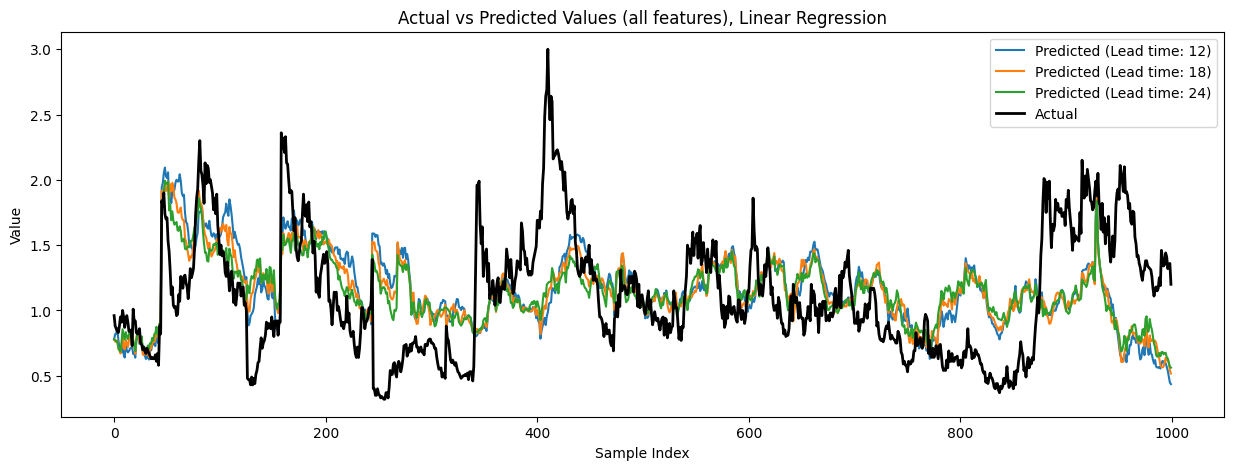

In [90]:
import matplotlib.pyplot as plt

N = 1000  

plt.figure(figsize=(15, 5))

for lead, (predictions, mse) in models.items():
    plt.plot(predictions[:N], label=f'Predicted (Lead time: {lead})')

plt.plot(y_val[:N], label='Actual', color='black', linewidth=2)

plt.title('Actual vs Predicted Values (all features), Linear Regression')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


As we can see, all different lead times follow the same general pattern – they all mimic the actual wave heights, just a few time steps later. This is because our model suffers from lagging, i.e. it is predicting current wave heights by upweighting previously seen data.

### Normalizing Data

In [94]:
wvht_scaler = StandardScaler()
all_wave_data_46240_scaled = all_wave_data_46240.copy()
all_wave_data_46240_scaled['WVHT'] = wvht_scaler.fit_transform(all_wave_data_46240[['WVHT']])

In [101]:
# normalize the input data since our features are on different scales / units
columns_to_normalize = ['DPD', 'APD', 'MWD', 'WDIR', 'WSPD', 'PRES', 'ATMP']
scaler_other = StandardScaler()
all_wave_data_46240_scaled[columns_to_normalize] = scaler_other.fit_transform(all_wave_data_46240[columns_to_normalize])

KeyError: "['WDIR', 'WSPD', 'PRES', 'ATMP'] not in index"

In [96]:
train_df_scaled = all_wave_data_46240_scaled[all_wave_data_46240_scaled.index.year <= 2018]
val_df_scaled = all_wave_data_46240_scaled[(all_wave_data_46240_scaled.index.year == 2019) | (all_wave_data_46240_scaled.index.year == 2020)]

# WE WILL NOT TOUCH THIS UNTIL THE FINAL MODEL
test_df_scaled = all_wave_data_46240_scaled[(all_wave_data_46240_scaled.index.year == 2021) | (all_wave_data_46240.index.year == 2022)]

In [97]:
missing_indices_train_scaled = data.check_for_missing_rows(train_df_scaled)
len(missing_indices_train_scaled)

614

In [98]:
missing_indices_val_scaled = data.check_for_missing_rows(val_df_scaled)
len(missing_indices_val_scaled)

49

In [99]:
missing_indices_test_scaled = data.check_for_missing_rows(test_df_scaled)
len(missing_indices_test_scaled)

16

### Simple XGBoost

In [91]:
from xgboost import XGBRegressor

leads = [12, 18, 24]
boost = {}
for lead in leads:
    print("Lead time:", lead)
    X_train = datasets[lead]['train'][0]
    y_train = datasets[lead]['train'][1]
    X_val = datasets[lead]['val'][0]
    y_val = datasets[lead]['val'][1]

    bst = XGBRegressor(n_estimators=30, max_depth=6, eta=0.1, subsample=0.8, colsample_bytree=0.8)
    bst.fit(X_train, y_train)
    preds = bst.predict(X_val)  

    mse = mean_squared_error(y_val, preds)  
    print("Mean Squared Error:", mse)
    print("----------------")

    boost[lead] = (preds, mse)



Lead time: 12
Mean Squared Error: 0.09807400140348316
----------------
Lead time: 18
Mean Squared Error: 0.10870882103979142
----------------
Lead time: 24
Mean Squared Error: 0.11726286130995099
----------------


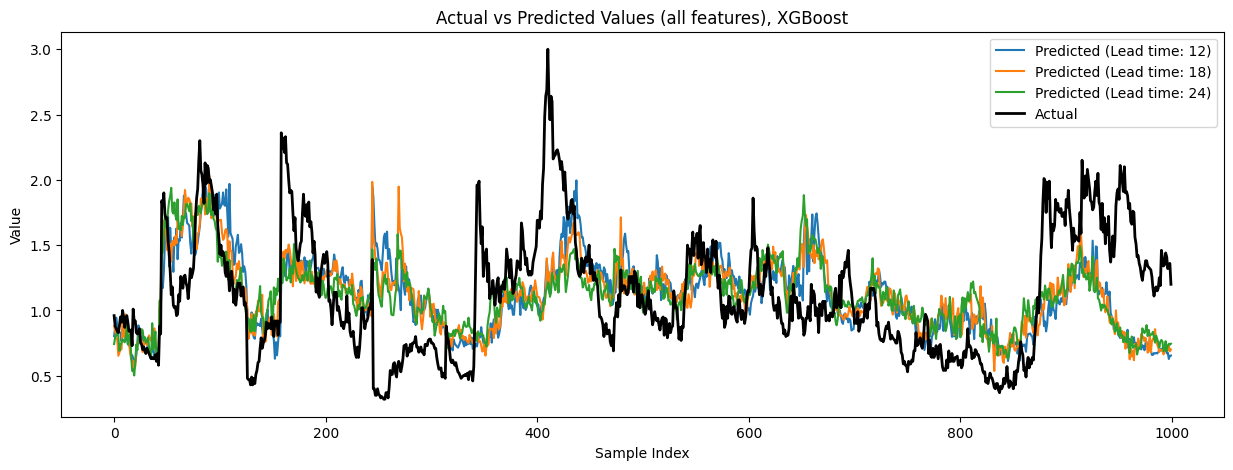

In [92]:
import matplotlib.pyplot as plt

N = 1000  

plt.figure(figsize=(15, 5))

for lead, (predictions, mse) in boost.items():
    plt.plot(predictions[:N], label=f'Predicted (Lead time: {lead})')

plt.plot(y_val[:N], label='Actual', color='black', linewidth=2)

plt.title('Actual vs Predicted Values (all features), XGBoost')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


### Linear Regressor with Normalized Data

In [100]:
X_train_scaled, y_train_scaled = data.build_supervised_learning_dataset(dataframe=train_df_scaled,
                                                          missing_indices=missing_indices_train_scaled,
                                                          feature_set=['DPD', 'APD', 'MWD', 'WDIR', 'WSPD', 'PRES', 'ATMP'],
                                                          window=48,
                                                          step=1,
                                                          lead=48)

print(f'X_train shape: {X_train.shape} y_train shape: {y_train.shape}')

KeyError: "['WDIR', 'WSPD', 'PRES', 'ATMP'] not in index"

In [ ]:
X_val_scaled, y_val_scaled = data.build_supervised_learning_dataset(dataframe=val_df_scaled,
                                                      missing_indices=missing_indices_val_scaled,
                                                      feature_set=['DPD', 'APD', 'MWD', 'WDIR', 'WSPD', 'PRES', 'ATMP'],
                                                      window=12,
                                                      step=12,
                                                      lead=48)

print(f'X_val shape: {X_val.shape} y_val shape: {y_val.shape}')

X_val shape: (16007, 60) y_val shape: (16007,)


In [ ]:
import statsmodels.api as sm

model = sm.OLS(y_train_scaled, X_train_scaled)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.206
Model:                            OLS   Adj. R-squared (uncentered):              0.206
Method:                 Least Squares   F-statistic:                              332.8
Date:                Thu, 07 Dec 2023   Prob (F-statistic):                        0.00
Time:                        16:06:20   Log-Likelihood:                     -1.0187e+05
No. Observations:               76915   AIC:                                  2.039e+05
Df Residuals:                   76855   BIC:                                  2.044e+05
Df Model:                          60                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0119      0.005      2.212      0.027       0.001       0.022
x2             0.0085      0.004      2.035      0.042       0.000       0.017
x3             0.0354      0.005      6.840      0.000       0.025       0.046
x4            -0.0080      0.004     -2.235      0.025      -0.015      -0.001
x5            -0.0933      0.011     -8.274      0.000      -0.115      -0.071
x6             0.0121      0.007      1.777      0.076      -0.001       0.025
x7             0.0049      0.004      1.120      0.263      -0.004       0.014
x8             0.0057      0.006      0.988      0.323      -0.006       0.017
x9            -0.0109      0.004     -3.016      0.003      -0.018      -0.004
x10           -0.0178      0.013     -1.328      0.184      -0.044       0.008
x11            0.0134      0.007      1.954      0.051   -3.92e-05       0.027
x12            0.0147      0.004      3.319      0.001       0.006       0.023
x13            0.0159      0.006      2.687      0.007       0.004       0.028
x14           -0.0115      0.004     -3.149      0.002      -0.019      -0.004
x15            0.0270      0.014      1.913      0.056      -0.001       0.055
x16            0.0214      0.007      3.118      0.002       0.008       0.035
x17            0.0061      0.004      1.371      0.170      -0.003       0.015
x18            0.0227      0.006      3.806      0.000       0.011       0.034
x19           -0.0109      0.004     -3.010      0.003      -0.018      -0.004
x20            0.0349      0.014      2.456      0.014       0.007       0.063
x21         4.436e-05      0.007      0.006      0.995      -0.013       0.013
x22            0.0062      0.004      1.393      0.164      -0.003       0.015
x23            0.0370      0.006      6.200      0.000       0.025       0.049
x24           -0.0075      0.004     -2.056      0.040      -0.015      -0.000
x25            0.0184      0.014      1.296      0.195      -0.009       0.046
x26            0.0250      0.007      3.656      0.000       0.012       0.038
x27            0.0033      0.004      0.744      0.457      -0.005       0.012
x28            0.0320      0.006      5.364      0.000       0.020       0.044
x29           -0.0067      0.004     -1.851      0.064      -0.014       0.000
x30            0.0271      0.014      1.906      0.057      -0.001       0.055
x31           -0.0020      0.007     -0.287      0.774      -0.015       0.011
x32           -0.0013      0.004     -0.299      0.765      -0.010       0.007
x33            0.0213      0.006      3.562      0.000       0.010       0.033
x34            0.0025      0.004      0.675      0.500      -0.005       0.010
x35           -0.0183      0.014     -1.287      0.198      -

In [ ]:
from sklearn.metrics import mean_squared_error

predictions = result.predict(X_val_scaled)  
mse = mean_squared_error(y_val_scaled, predictions)  
print("Mean Squared Error:", mse)

Mean Squared Error: 0.6999556588461411


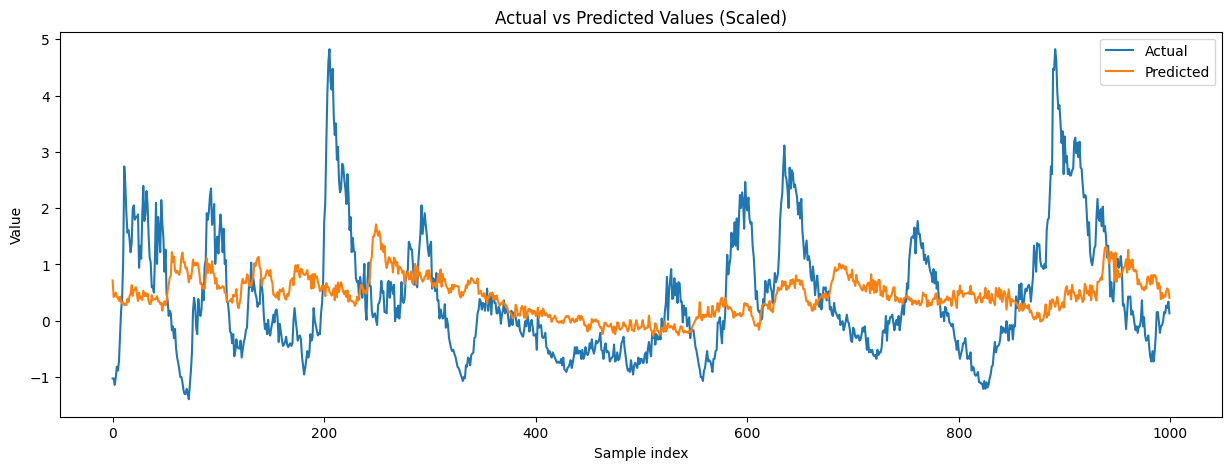

In [ ]:
predictions_np = predictions.reshape(-1, 1)  # Reshape for scaler
y_val_np = y_val_scaled.reshape(-1, 1)              # Reshape for scaler

# Unscale predictions and actual values
predictions_unscaled = wvht_scaler.inverse_transform(predictions_np).flatten()
y_val_unscaled = wvht_scaler.inverse_transform(y_val_np).flatten()
        
plt.figure(figsize=(15, 5))
plt.plot(y_val_unscaled[:1000], label='Actual')
plt.plot(predictions_unscaled[:1000], label='Predicted')
plt.title('Actual vs Predicted Values (Scaled)')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.show()

### Long Short-Term Memory

In [32]:
X_train, y_train = data.build_supervised_learning_dataset(dataframe=train_df,
                                                          missing_indices=missing_indices_train,
                                                          feature_set=['WVHT', 'DPD', 'APD', 'MWD'],
                                                          window=12,
                                                          step=12,
                                                          lead=48)

X_val, y_val = data.build_supervised_learning_dataset(dataframe=val_df,
                                                      missing_indices=missing_indices_val,
                                                      feature_set=['WVHT', 'DPD', 'APD', 'MWD'],
                                                      window=12,
                                                      step=12,
                                                      lead=48)

print(f'X_train shape: {X_train.shape} y_train shape: {y_train.shape}')

X_train shape: (76915, 48) y_train shape: (76915,)


In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam

input_shape = (12, 4)  # 12 timesteps and 4 features

def build_multistep_lstm_model(input_shape, output_steps):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(50))
    model.add(Dropout(0.3))
    model.add(Dense(output_steps))  # Output layer with neurons equal to the prediction horizon
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Build the model
output_steps = 1  
lstm_model = build_multistep_lstm_model(input_shape, output_steps)
lstm_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12, 50)            11000     
                                                                 
 dropout_6 (Dropout)         (None, 12, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31251 (122.07 KB)
Trainable params: 31251 (122.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt

X_train = X_train.reshape((-1, 12, 4))
X_val = X_val.reshape((-1, 12, 4))

class PredictionHistory(Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val
        self.predictions = []
    
    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.X_val)
        self.predictions.append(y_pred)

# Instantiate the callback with validation data
prediction_history = PredictionHistory(X_val, y_val)

# Fit the model with the new callback
history = lstm_model.fit(X_train, y_train, epochs=25, batch_size=32, 
                         validation_data=(X_val, y_val), 
                         callbacks=[prediction_history])

(76915,)
Epoch 1/25
1162/2404 [=============>................] - ETA: 5s - loss: 0.2035

KeyboardInterrupt: 